In [1]:
#Miles' packages
from astropy.table import Table
import astropy.coordinates as coord
import glob
from astropy import units as u

#data processing
import pandas as pd
import numpy as np
import math as math
from tqdm import tqdm
import collections
import copy

#visualizations
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.use('Agg')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

#models
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#data manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#for my sanity
import warnings
warnings.filterwarnings('ignore')

In [2]:
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [3]:
stream_data_base = 'gaia_mock_streams/'
stream_files = glob.glob(stream_data_base + 'stream*.fits.gz')

We now have all the stream files:

In [4]:
print(len(stream_files))
stream_files[:5]

322


['gaia_mock_streams/stream-178.fits.gz',
 'gaia_mock_streams/stream-9528.fits.gz',
 'gaia_mock_streams/stream-9549.fits.gz',
 'gaia_mock_streams/stream-1954.fits.gz',
 'gaia_mock_streams/stream-2408.fits.gz']

In [5]:
#relevant cut for each stream
cuts = pd.read_csv("cuts/cuts3.csv")

#### let us write a function to extract the Gaia noise points based on some inputs

In [7]:
def obtain_noise(min_ra, max_ra, min_dec, max_dec, max_rel_err, n_points):
    
    qry = f" \n\
    select top {n_points} source_id, \n\
    dr2.ra, \n\
    dr2.dec, \n\
    parallax, \n\
    parallax_error, \n\
    pmra, \n\
    pmdec, \n\
    phot_g_mean_mag,\n\
    phot_bp_mean_mag, \n\
    phot_rp_mean_mag, \n\
    bp_rp, \n\
    bp_g, \n\
    g_rp\n\
    from gaiadr2.gaia_source as dr2 \n\
    where dr2.ra > {min_ra} and dr2.ra < {max_ra} and dr2.dec > {min_dec} and dr2.dec < {max_dec} \n\
    and parallax is not null \n\
    and parallax_error is not null \n\
    and abs(dr2.parallax/dr2.parallax_error) < {max_rel_err} \n\
    and pmra is not null \n\
    and pmdec is not null \n\
    and phot_g_mean_mag is not null \n\
    and phot_bp_mean_mag is not null \n\
    and phot_rp_mean_mag is not null \n\
    and bp_rp is not null \n\
    and bp_g is not null \n\
    and g_rp is not null \n\
    order by random_index"

    data_noise = Gaia.launch_job_async(qry).get_results().to_pandas()
    
    return data_noise

#### Let us define our potential models here

In [8]:
#let us define a function to run logistic regression on our data set and evaluate the results
def log_reg_model(X_train, X_test, y_train, y_test):
    #do the logistic regression modeling
    log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, multi_class='warn').fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

def knn_model(X_train, X_test, y_train, y_test, k):
    #do the KNN modeling
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

#### For each mock stream, we wish to obtain a fixed test set that represents the realistic ratio of non-stream stars to stream stars that we expect after applying an isochrone filter.
#### - This ratio was previously determined to be ~400

In [9]:
def obtain_test_set(list_of_stellar_streams, multiple):

    for i in list_of_stellar_streams:
        table = Table.read(i, format='fits')
        stream = table.to_pandas()
        
        idx = cuts.index[cuts.stream_file==str(i)][0]

        ra_min = cuts.loc[idx].ra_min
        ra_max = cuts.loc[idx].ra_max
        dec_min = cuts.loc[idx].dec_min
        dec_max = cuts.loc[idx].dec_max
        
        #restrict stream to relevant portion
        stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

        #obtain noise points such that:
        #- the ratio of stream to noise points in the test set is 1:multiple
        #- this is required because KNN introduces bias when the ratios are imbalanced
        n_points = len(stream) * multiple
        #use max_rel_err of 0.5
        max_rel_err =  0.5

        #we now select our noise points that we will incorporate into our training and test set
        noise_points = obtain_noise(ra_min, ra_max, dec_min, dec_max, max_rel_err, n_points)

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False
        
        #send to csv
        name = i[18:-8]+'_mul_400_total_noise.csv'
        noise_points.to_csv(name)

    return noise_points

In [23]:
viable_streams = []

for i in cuts.stream_file:
    table = Table.read(i, format='fits')
    stream = table.to_pandas()
    
    idx = cuts.index[cuts.stream_file==str(i)][0]

    ra_min = cuts.loc[idx].ra_min
    ra_max = cuts.loc[idx].ra_max
    dec_min = cuts.loc[idx].dec_min
    dec_max = cuts.loc[idx].dec_max

    #restrict stream to relevant portion
    stream2 = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))
    
    if len(stream2) < 500 and len(stream2) > 25:
        viable_streams.append(i)

####ONLY NEED TO RUN THIS ONCE
# test2 = obtain_test_set(viable_streams,400)

In [29]:
#exclude the first one (2985 not needed here)
viable_new = viable_streams[1:]

#### Train a KNN model

In [30]:
def knn_simulated_stream(stream_name, k_optimal, multiple, train_ratio):

    table = Table.read(stream_name, format='fits')
    stream = table.to_pandas()
    
    idx = cuts.index[cuts.stream_file==stream_name][0]

    ra_min = cuts.loc[idx].ra_min
    ra_max = cuts.loc[idx].ra_max
    dec_min = cuts.loc[idx].dec_min
    dec_max = cuts.loc[idx].dec_max

    #restrict stream to relevant portion
    stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

    #label our data as "part of the stream"
    stream['stream_mask'] = True

    #split data into training and training data set
    msk = np.random.rand(len(stream)) < train_ratio
    stream_train = stream[msk]
    stream_test = stream[~msk]


    #obtain noise points such that:
    #- the ratio of stream to noise points in the training set is 1:multiple
    #- the ratio of stream to noise points in the test set is close to the 'real' ratio
    name = "noise_points/" + stream_name[18:-8] + "_mul_400_total_noise.csv"
    noise_points = pd.read_csv(name)
    train_points = len(stream_train) * multiple

    msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
    noise_train = noise_points[msk2]
    noise_test = noise_points[~msk2]
    
    #label our data as "not part of the stream"
    noise_points['stream_mask'] = False

    #combine my stream and noise to obtain complete training and test data set
    training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
    training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

    testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
    testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

    #differentiate training and test data's X and y variables
    X_train = training_data[['ra', 'dec', 'pmra', 'pmdec']]
    y_train = training_data.stream_mask

    X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec']]
    y_test = testing_data.stream_mask

    #scale the features using standard scaler (scaling not required for logistic regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit(X_train).transform(X_train)
    X_test_scaled = scaler.fit(X_test).transform(X_test)

    precision, recall, accuracy, auc, y_pred, y_true = knn_model(X_train_scaled, X_test_scaled, y_train, y_test, k_optimal)
        
    return precision, recall, accuracy, auc, y_pred, y_true


#### we try a combination of hyperparameters and record their vote

In [31]:
res1 = pd.read_csv('fixed_test_ratio_results.csv', index_col = 0)
res2 = pd.read_csv('fixed_test_ratio_results2.csv', index_col = 0)
res = res1.append(res2, ignore_index = True)

res['f1']= 2*(res.precision * res.recall)/(res.precision + res.recall)
#res.sort_values(by = 'f1',ascending = False).head(20)
#res.query('f1 > 0.701')
res3 = res.groupby(['k','multiple','training_ratio']).mean().sort_values(by = 'f1',ascending = False)
res3 = res3.reset_index()[['k','multiple','training_ratio']]
tuples_try = [(list(res3.k)[i], list(res3.multiple)[i], list(res3.training_ratio)[i]) for i in range(150)]

In [32]:
#restrict models only to models that train on 10% of stellar stream stars i.e. exclude models that use 20% of stars in stream
tuples_try_10 = [i for i in tuples_try if i[2] == 0.1]
len(tuples_try_10)

75

In [33]:
results = {}


for stream_name in tqdm(viable_new):
    table = Table.read(stream_name, format='fits')
    stream = table.to_pandas()

    idx = cuts.index[cuts.stream_file==stream_name][0]

    ra_min = cuts.loc[idx].ra_min
    ra_max = cuts.loc[idx].ra_max
    dec_min = cuts.loc[idx].dec_min
    dec_max = cuts.loc[idx].dec_max

    #restrict stream to relevant portion
    stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

    #label our data as "part of the stream"
    stream['stream_mask'] = True
    
    votes = []
    
    number_of_votes = 25
    for voter in tuples_try_10[:number_of_votes]:

        k_optimal = voter[0]
        multiple = voter[1]
        training_ratio = voter[2]
        
        
        #split data into training and training data set
        stream_train, stream_test = train_test_split(stream, test_size=1-training_ratio)

        #msk = np.random.rand(len(stream)) < training_ratio
        #stream_train = stream[msk]
        #stream_test = stream[~msk]


        #obtain noise points such that:
        #- the ratio of stream to noise points in the training set is 1:multiple
        #- the ratio of stream to noise points in the test set is close to the 'real' ratio
        name = "noise_points/" + stream_name[18:-8] + "_mul_400_total_noise.csv"
        noise_points = pd.read_csv(name)
        train_points = len(stream_train) * multiple
        
        noise_train = noise_points.sample(n=train_points,random_state = 25)
        leftover_noise = pd.concat([noise_points,noise_train]).drop_duplicates(keep=False)
        n_points = round(len(noise_points)*0.8)
        noise_test = leftover_noise.sample(n=n_points,random_state = 25)
        
        #ratio2 = train_points / len(noise_points)
        #noise_train, noise_test = train_test_split(noise_points, test_size= ratio2)
        #msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
        #noise_train = noise_points[msk2]
        #noise_test = noise_points[~msk2]

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False

        #combine my stream and noise to obtain complete training and test data set
        training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
        training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

        testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
        testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

        #differentiate training and test data's X and y variables
        X_train = training_data[['ra', 'dec', 'pmra', 'pmdec']]
        y_train = training_data.stream_mask

        X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec']]
        y_test = testing_data.stream_mask

        #scale the features using standard scaler (scaling not required for logistic regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit(X_train).transform(X_train)
        X_test_scaled = scaler.fit(X_test).transform(X_test)

        precision, recall, accuracy, auc, y_pred, y_true = knn_model(X_train_scaled, X_test_scaled, y_train, y_test, k_optimal)
        votes.append(y_pred)
        
    for i in range(len(votes)):
        name_of_vote = 'voter_' + str(i)
        testing_data[name_of_vote] = votes[i]
    
        #trouble_shooting
        #print(len(y_pred), len(stream_train), len(noise_points), train_points, len(noise_train), len(noise_test), len(leftover_noise))
    
    results[stream_name]=testing_data


100%|██████████| 15/15 [29:54<00:00, 119.62s/it][A


In [34]:
res_temp = pd.DataFrame([results])
res_temp.to_csv('temp_results_ensemble_20191130.csv')

#### We tune for threshold

In [35]:
results_use = copy.deepcopy(results)
streams = list(results_use.keys())

#use the first 10 elements to tune the threshold
streams_threshold_tuning = streams[:10]
streams_predictions = streams[10:]
thresholds = np.arange(0.1,1,0.02).tolist()

In [36]:
for stream in streams_threshold_tuning:
    sum_of_votes = results_use[stream].drop(['ra','dec','pmra','pmdec','stream_mask'],axis=1).sum(axis=1)
    results_use[stream]['avg_of_votes'] = sum_of_votes / number_of_votes
    for threshold in thresholds:
        col_name = 'agg_vote'+str(round(threshold,2))
        results_use[stream][col_name] = np.where(results_use[stream].avg_of_votes > threshold, True, False)

In [37]:
results_use[streams_threshold_tuning[0]].head(10)

,ra,dec,pmra,pmdec,stream_mask,voter_0,voter_1,voter_2,voter_3,voter_4,...,agg_vote0.8,agg_vote0.82,agg_vote0.84,agg_vote0.86,agg_vote0.88,agg_vote0.9,agg_vote0.92,agg_vote0.94,agg_vote0.96,agg_vote0.98
90,234.241156,-18.511026,23.409427,-16.363313,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
194,122.977131,-24.208608,-0.186713,0.693346,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
152,139.171880,-60.578483,-3.391052,3.566792,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
34,246.194286,-54.916289,-10.068441,-9.471287,True,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
174,117.442504,-20.316668,0.155026,-0.458141,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
125,279.266550,-13.637801,-3.657540,-5.779000,True,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
202,243.406543,-55.945842,-8.706723,-9.704481,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
25,242.020875,-57.329169,-8.310642,-9.009278,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
41,135.085447,-54.008277,-1.886809,1.700781,True,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
172,118.933156,-18.695662,0.461267,-0.075328,True,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [38]:
threshold_dictionary = {}

for threshold in thresholds:
    col_name = 'agg_vote'+str(round(threshold,2))

    stream_name_ens = []
    true_positives = []
    false_positives = []
    true_negatives = []
    false_negatives = []

    for stream_index in range(len(streams_threshold_tuning)):
        y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
        y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
        #Truly in Cluster
        X_correct = results_use[streams_threshold_tuning[stream_index]][y_test & y_pred] #predicted in cluster (true positives)
        X_incorrect = results_use[streams_threshold_tuning[stream_index]][y_test & ~y_pred] #predicted not in cluster (false negative)
        #Truly not in Cluster
        X2_correct = results_use[streams_threshold_tuning[stream_index]][~y_test & ~y_pred] #predicted not in cluster (true negative)
        X2_incorrect = results_use[streams_threshold_tuning[stream_index]][~y_test & y_pred] #predicted in cluster (false positive)

        stream_name_ens.append(streams_threshold_tuning[stream_index])
        true_positives.append(len(X_correct))
        false_positives.append(len(X2_incorrect))
        true_negatives.append(len(X2_correct))
        false_negatives.append(len(X_incorrect))

    final_result = pd.DataFrame()
    final_result['stream']= stream_name_ens
    final_result['true_positives']=true_positives
    final_result['false_positives']=false_positives
    final_result['true_negatives']=true_negatives
    final_result['false_negatives']=false_negatives
    final_result['precision'] = final_result.true_positives / (final_result.true_positives + final_result.false_positives)
    final_result['recall'] = final_result.true_positives / (final_result.true_positives + final_result.false_negatives)
    final_result['f1'] = 2*(final_result.precision * final_result.recall)/(final_result.precision + final_result.recall)
    
    threshold_dictionary[col_name] = final_result

##### Prediction Visualization

0.2

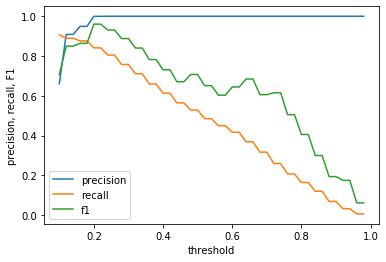

In [39]:
precision_thresholds_average = []
recall_thresholds_average = []
f1_thresholds_average = []

for threshold in thresholds:
    col_name = 'agg_vote'+str(round(threshold,2))
    precision_thresholds_average.append(threshold_dictionary[col_name].precision.mean())
    recall_thresholds_average.append(threshold_dictionary[col_name].recall.mean())
    f1_thresholds_average.append(threshold_dictionary[col_name].f1.mean())
        
plt.plot(thresholds,precision_thresholds_average, label = 'precision')
plt.plot(thresholds,recall_thresholds_average, label = 'recall')
plt.plot(thresholds,f1_thresholds_average, label = 'f1')
plt.xlabel('threshold')
plt.ylabel('precision, recall, F1')
plt.legend()

threshold_optimal = thresholds[np.argmax(f1_thresholds_average)]
threshold_optimal

#### Performance

In [45]:
threshold = threshold_optimal
for stream in streams_predictions:
    sum_of_votes = results_use[stream].drop(['ra','dec','pmra','pmdec','stream_mask'],axis=1).sum(axis=1)
    results_use[stream]['avg_of_votes'] = sum_of_votes / number_of_votes
    results_use[stream]['agg_vote'] = np.where(results_use[stream].avg_of_votes > threshold, True, False)

stream_name_ens = []
true_positives = []
false_positives = []
true_negatives = []
false_negatives = []

for stream_index in range(len(streams_predictions)):
    y_test = results_use[streams_predictions[stream_index]].stream_mask
    y_pred = results_use[streams_predictions[stream_index]].agg_vote
    #Truly in Cluster
    X_correct = results_use[streams_predictions[stream_index]][y_test & y_pred] #predicted in cluster (true positives)
    X_incorrect = results_use[streams_predictions[stream_index]][y_test & ~y_pred] #predicted not in cluster (false negative)
    #Truly not in Cluster
    X2_correct = results_use[streams_predictions[stream_index]][~y_test & ~y_pred] #predicted not in cluster (true negative)
    X2_incorrect = results_use[streams_predictions[stream_index]][~y_test & y_pred] #predicted in cluster (false positive)
    
    stream_name_ens.append(streams_predictions[stream_index])
    true_positives.append(len(X_correct))
    false_positives.append(len(X2_incorrect))
    true_negatives.append(len(X2_correct))
    false_negatives.append(len(X_incorrect))
    
final_result = pd.DataFrame()
final_result['stream']= stream_name_ens
final_result['true_positives']=true_positives
final_result['false_positives']=false_positives
final_result['true_negatives']=true_negatives
final_result['false_negatives']=false_negatives
final_result['precision'] = final_result.true_positives / (final_result.true_positives + final_result.false_positives)
final_result['recall'] = final_result.true_positives / (final_result.true_positives + final_result.false_negatives)
final_result['f1'] = 2*(final_result.precision * final_result.recall)/(final_result.precision + final_result.recall)

In [46]:
final_result.to_csv('ensemble3_20191130.csv')
final_result

,stream,true_positives,false_positives,true_negatives,false_negatives,precision,recall,f1
0,gaia_mock_streams/stream-5797.fits.gz,184,0,65280,0,1.000000,1.000000,1.000000
1,gaia_mock_streams/stream-1324.fits.gz,85,0,30080,0,1.000000,1.000000,1.000000
2,gaia_mock_streams/stream-9420.fits.gz,86,1,30399,0,0.988506,1.000000,0.994220
3,gaia_mock_streams/stream-3696.fits.gz,67,0,23680,0,1.000000,1.000000,1.000000
4,gaia_mock_streams/stream-9833.fits.gz,5,0,10240,24,1.000000,0.172414,0.294118


##### Visualization

In [66]:
for stream in streams_predictions:
    sum_of_votes = results_use[stream].drop(['ra','dec','pmra','pmdec','stream_mask'],axis=1).sum(axis=1)
    results_use[stream]['avg_of_votes'] = sum_of_votes / number_of_votes
    results_use[stream]['agg_vote'] = np.where(results_use[stream].avg_of_votes > threshold_optimal, True, False)

In [74]:
results_use['gaia_mock_streams/stream-5797.fits.gz']

,ra,dec,pmra,pmdec,stream_mask,voter_0,voter_1,voter_2,voter_3,voter_4,...,voter_17,voter_18,voter_19,voter_20,voter_21,voter_22,voter_23,voter_24,avg_of_votes,agg_vote
69,6.481217,-46.877384,1.131687,-0.109039,True,False,True,False,False,True,...,True,False,True,False,False,False,True,True,0.458240,True
34,211.355359,-74.264577,-0.805646,-1.916964,True,False,True,True,False,True,...,True,True,True,True,False,False,False,False,0.499904,True
23,207.850324,-69.639804,-0.684503,-1.718796,True,True,False,False,True,True,...,True,True,True,True,True,False,False,False,0.541568,True
145,7.337438,-17.759021,0.217245,-0.423871,True,True,True,False,False,True,...,True,True,True,True,False,False,False,True,0.666560,True
63,201.563070,-46.500287,-1.468647,-2.240726,True,True,True,True,False,True,...,True,True,True,False,False,True,False,False,0.541568,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38997,166.645186,-59.694222,-5.876401,6.049531,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.000000,False
62328,264.178570,-45.921228,6.007867,-1.320921,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.000000,False
50280,266.062272,-15.446338,-4.966817,-6.694153,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.000000,False
11511,282.777112,-33.737650,-1.248500,-3.833019,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.000000,False


gaia_mock_streams/stream-9420.fits.gz
Number of true positives is 86
Number of false positives is 15
Number of true negatives is 30385
Number of false negatives is 0


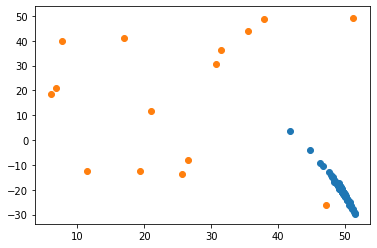

In [67]:
#Plot performance for Stream in index from 0 to len(streams)
stream_index = 2
y_test = results_use[streams_predictions[stream_index]].stream_mask
y_pred = results_use[streams_predictions[stream_index]].agg_vote
#Truly in Cluster
X_correct = results_use[streams_predictions[stream_index]][y_test & y_pred] #predicted in cluster (true positives)
X_incorrect = results_use[streams_predictions[stream_index]][y_test & ~y_pred] #predicted not in cluster (false negative)
#Truly not in Cluster
X2_correct = results_use[streams_predictions[stream_index]][~y_test & ~y_pred] #predicted not in cluster (true negative)
X2_incorrect = results_use[streams_predictions[stream_index]][~y_test & y_pred] #predicted in cluster (false positive)

X_correct['label']=1
X_incorrect['label']=1
X2_correct['label']=0
X2_incorrect['label']=0

#visualize true and false positives
plt.scatter(X_correct['ra'], X_correct['dec'])
plt.scatter(X2_incorrect['ra'], X2_incorrect['dec'])


#plt.scatter(X2_correct['pmra'], X2_correct['pmdec'])
#plt.scatter(X_incorrect['pmra'], X_incorrect['pmdec'])

#This takes true positives and false positives
X_pred_pos = X_correct.append(X2_incorrect, ignore_index = False, sort = True)
print(streams_predictions[stream_index])
print('Number of true positives is ' + str(len(X_correct)))
print('Number of false positives is ' + str(len(X2_incorrect)))
print('Number of true negatives is ' + str(len(X2_correct)))
print('Number of false negatives is ' + str(len(X_incorrect)))


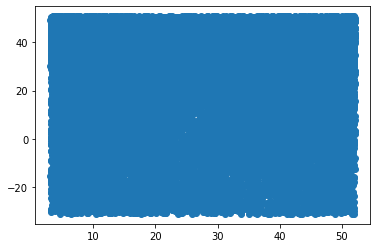

In [64]:
#visualize true and false positives
plt.scatter(X2_correct['ra'], X2_correct['dec'])
plt.scatter(X_incorrect['ra'], X_incorrect['dec'])

##### Evaluate performance on GD1

In [76]:
filename = "~/Data/gd1_in_gaia.h5"
dataset = pd.read_hdf(filename, 'df')

In [98]:
#separate the data points that belong to GD1
dataset_gd1 = dataset[dataset['pm_mask'] == True]
dataset_gd1 = dataset_gd1[dataset_gd1['gi_cmd_mask'] == True]
dataset_gd1 = dataset_gd1[dataset_gd1['stream_track_mask'] == True]
dataset_gd1['in_gd1'] = 1

#separate the data points that do not belong to GD1 AND have passed through the isochrone filter
dataset_nongd = dataset[(dataset['pm_mask']== False) | (dataset['gi_cmd_mask'] == False)]
dataset_nongd = dataset_nongd[dataset_nongd['stream_track_mask'] == True]
dataset_nongd['in_gd1'] = 0

In [87]:
combined_df = dataset_gd1.append(dataset_nongd, ignore_index = False)
#X = combined_df[['ra','dec','pmra_x', 'pmdec_x']]
#y = combined_df['in_gd1']

In [100]:
len(dataset_gd1), len(dataset_nongd)

(1979, 713993)

In [113]:
votes = []

number_of_votes = 25
for voter in tuples_try_10[:number_of_votes]:

    k_optimal = voter[0]
    multiple = voter[1]
    training_ratio = voter[2]


    #split data into training and training data set
    stream_train, stream_test = train_test_split(dataset_gd1, test_size=1-training_ratio)

    train_points = len(stream_train) * multiple

    noise_train = dataset_nongd.sample(n=train_points,random_state = 25)
    leftover_noise = pd.concat([dataset_nongd,noise_train]).drop_duplicates(keep=False)
    n_points = round(len(dataset_nongd)*0.8)
    noise_test = leftover_noise.sample(n=n_points,random_state = 25)

    #combine my stream and noise to obtain complete training and test data set
    training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
    training_data = training_data[['ra', 'dec', 'pmra_x', 'pmdec_x', 'in_gd1']]

    testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
    testing_data = testing_data[['ra', 'dec', 'pmra_x', 'pmdec_x', 'in_gd1']]
    testing_data = testing_data.dropna()

    #differentiate training and test data's X and y variables
    X_train = training_data[['ra', 'dec', 'pmra_x', 'pmdec_x']]
    y_train = training_data.in_gd1

    X_test = testing_data[['ra', 'dec', 'pmra_x', 'pmdec_x']]
    y_test = testing_data.in_gd1

    #scale the features using standard scaler (scaling not required for logistic regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit(X_train).transform(X_train)
    X_test_scaled = scaler.fit(X_test).transform(X_test)

    precision, recall, accuracy, auc, y_pred, y_true = knn_model(X_train_scaled, X_test_scaled, y_train, y_test, k_optimal)
    votes.append(y_pred)

In [115]:
for i in range(len(votes)):
    name_of_vote = 'voter_' + str(i)
    testing_data[name_of_vote] = votes[i]

In [122]:
testing_data.to_csv('ensemble_gd1.csv')

In [120]:
threshold = threshold_optimal

sum_of_votes = testing_data.drop(['ra','dec','pmra_x','pmdec_x','in_gd1'],axis=1).sum(axis=1)
testing_data['avg_of_votes'] = sum_of_votes / number_of_votes
testing_data['agg_vote'] = np.where(testing_data.avg_of_votes > threshold, True, False)

y_test = testing_data.in_gd1
y_pred = testing_data.agg_vote
#Truly in Cluster
X_correct = testing_data[y_test & y_pred] #predicted in cluster (true positives)
X_incorrect = testing_data[y_test & ~y_pred] #predicted not in cluster (false negative)
#Truly not in Cluster
X2_correct = testing_data[~y_test & ~y_pred] #predicted not in cluster (true negative)
X2_incorrect = testing_data[~y_test & y_pred] #predicted in cluster (false positive)
precision_gd1 = len(X_correct)/(len(X_correct) + len(X2_incorrect))
recall_gd1 = len(X_correct)/(len(X_correct) + len(X_incorrect))
f1_gd1 = 2*(precision_gd1 * recall_gd1)/(precision_gd1+recall_gd1)

print('Number of true positives is ' + str(len(X_correct)))
print('Number of false positives is ' + str(len(X2_incorrect)))
print('Number of true negatives is ' + str(len(X2_correct)))
print('Number of false negatives is ' + str(len(X_incorrect)))
print('Precision is ' + str(precision_gd1))
print('Recall is ' + str(recall_gd1))
print('F1 score is ' + str(f1_gd1))

Number of true positives is 1172
Number of false positives is 29
Number of true negatives is 571165
Number of false negatives is 610
Precision is 0.9758534554537885
Recall is 0.6576879910213244
F1 score is 0.7857861213543412


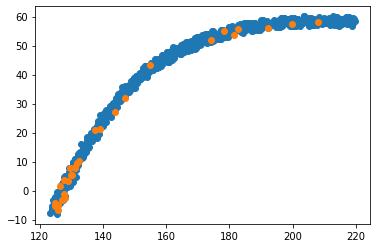

In [123]:
plt.scatter(X_correct['ra'], X_correct['dec'])
plt.scatter(X2_incorrect['ra'], X2_incorrect['dec'])

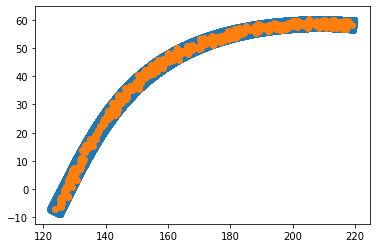

In [124]:
plt.scatter(X2_correct['ra'], X2_correct['dec'])
plt.scatter(X_incorrect['ra'], X_incorrect['dec'])